In [31]:
import pandas as pd # used to load individual files
import numpy as np # not currently used
import datetime as dt # not currently used
#from geopy.distance import geodesic might be used at some point
#import peartree as pt # used to construct network
import matplotlib.pyplot as plt
import osmnx as ox # visualisation library for networks
%matplotlib inline
import pickle
import networkx as nx
import geopandas as gp
from collections import defaultdict
from geopy.distance import geodesic
from tqdm import tqdm
from sklearn.neighbors import BallTree
import math

In [3]:
with open('rejsekort_graph_cleaned.gpickle', 'rb') as f:
    G = pickle.load(f)

# Relabels nodes by removing WPDOS_ from each node
# relabel_dic = {node:node[6:] for node in G.nodes()}
# G = nx.relabel_nodes(G, relabel_dic, copy=False)



In [4]:
print(nx.number_weakly_connected_components(G))


30


In [25]:
len(ccs[1])

13456

In [37]:
# for edge in G.edges():
#     edge = G.get_edge_data(*edge)
#     print(edge)


In [5]:
set_unknown = set()
with open("data/transfers.txt") as f:
    transfers = pd.read_csv(f, sep=",",dtype=str)
    for idx in range(len(transfers)):
        line = transfers.iloc[idx]
        node1 = line.from_stop_id
        node2 = line.to_stop_id
        length = line.min_transfer_time
        if node1 not in G.nodes():
            set_unknown.add(node1)
        if node2 not in G.nodes():
            set_unknown.add(node2)    
        # G.add_edge(node1, node2, mode = 'transfer', length=length)

print(len(node2))

12


In [6]:
list(set_unknown)[2]

'000835000402'

In [7]:
len(set_unknown)

261

In [8]:
len(G.nodes())
len(G.edges)

52656

/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/opt/conda/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


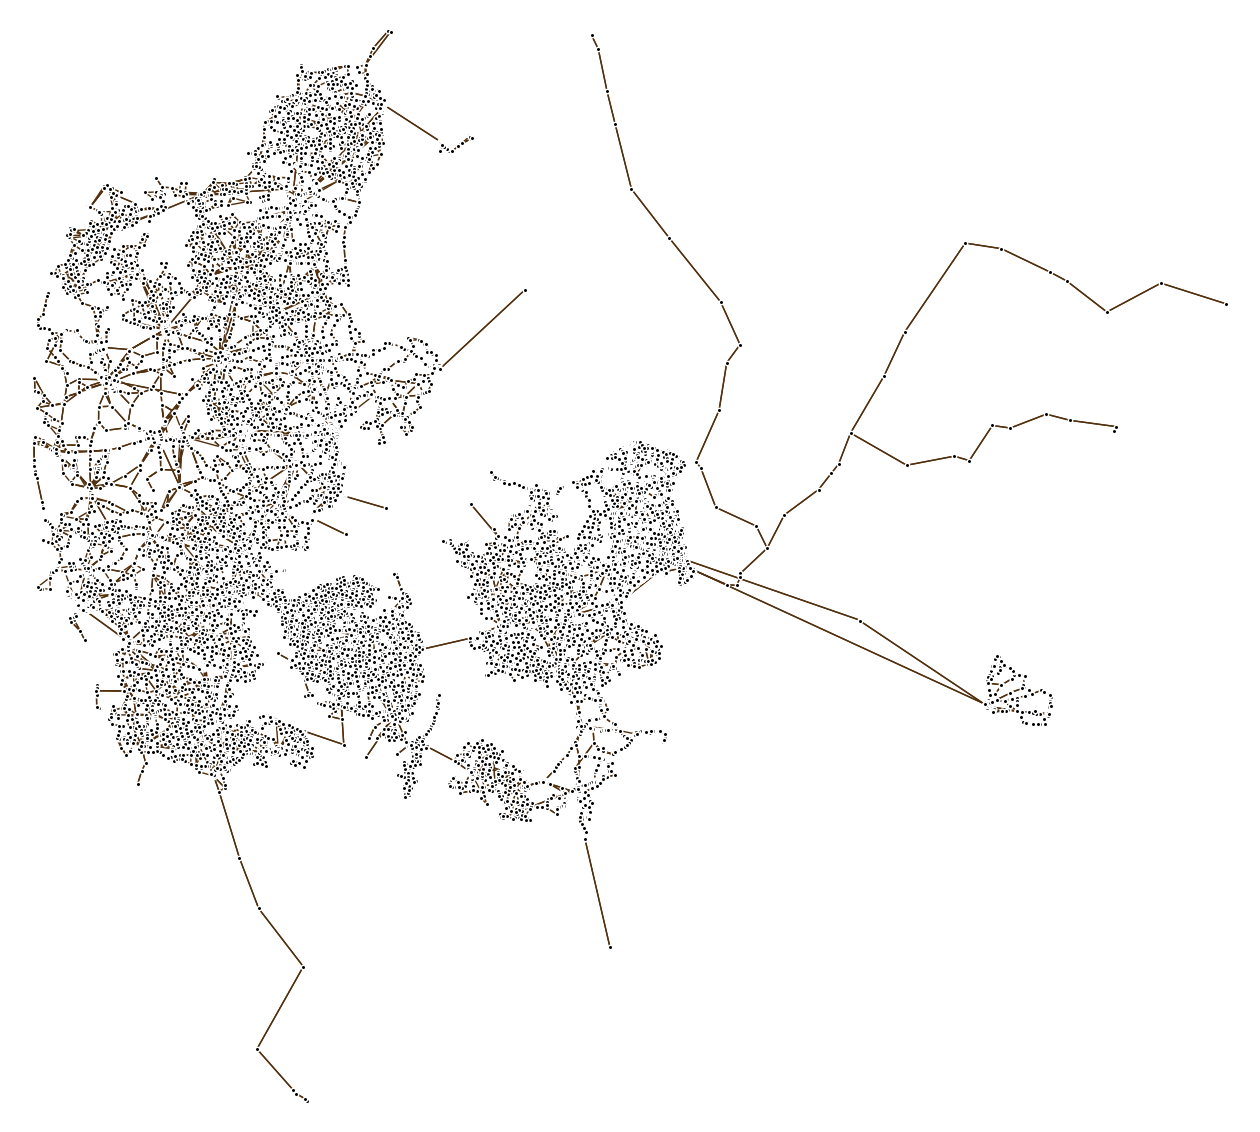

In [10]:
fig, ax = ox.plot_graph(G,
               figsize = (16,16),
                show=False,
                close=False,
                node_color='black',
                node_edgecolor="white",
                node_size=10,
                node_zorder=10,
                edge_color='#522F0D',
                edge_alpha=1,
                edge_linewidth = 1,
                bgcolor='None',
                #bbox= bbox_,
               #bgcolor='black'
              
             );

Modes of transport from GTFS reference
109 s-tog
700 bus
715 demand and response bus service
0 letbanen lightrail
1 is metro
2 train/intercity
3 localtog and bus?
4 ferry maybe other too?

Types of busses
S bus is fast and direct bus routes
e bus are express buslines during rush hour
p bus are local buses
n bus are night buses
havn bus




In [11]:
modes= [G.nodes[node]["modes"] for node in G.nodes()]
uniqmodes = set()
for mode in modes:
    uniqmodes = uniqmodes.union(set(mode))
uniqmodes

{'0', '1', '109', '2', '3', '4', '700', '715'}

In [12]:
edges = G.edges()

In [14]:
G.nodes()['000000000002']

{'boarding_cost': 1681.8,
 'modes': ['3'],
 'y': 55.767248497366,
 'x': 12.498017540594}

In [15]:
G['000000000002']

AdjacencyView({'000000000003': {0: {'length': 60.0, 'mode': 'transit'}}})

In [16]:
mode_counts=defaultdict(int)
for edge in G.edges():
    edge = G.get_edge_data(*edge)
    mode_counts[edge[0]['mode']] += 1
print(mode_counts)

defaultdict(<class 'int'>, {'transit': 52656})


In [38]:
def tacicab_sphere(latlong1,latlong2):
    '''
    Returns the taxicab distance between two points on a sphere (given lat-long pairs).
    Formula: http://cs.ucmo.edu/~mjms/2005.1/bayar.pdf
    '''
    x1,y1 = latlong1
    x2,y2 = latlong2
    return min(
        geodesic((x1,y1),(x2,y1)).meters + geodesic((x2,y1),(x2,y2)).meters,
        geodesic((x1,y1),(x1,y2)).meters + geodesic((x1,y2),(x2,y2)).meters
    )

def m2s(m):
    return m/1.25 #Walking speed used by Google Maps

# Conversion function for input to BallTree
def convert_latlon_to_balltree_input(lat, lon):
    return np.vstack([np.radians(lon), np.radians(90-np.array(lat))]).T

In [18]:
''' Bad Code
def add_walk_edges(G):
    G = G.copy()
    for node1 in tqdm(G.nodes()):
        for node2 in G.nodes():
            if node1 == node2:
                continue
            for (u,v,edge_type) in G.edges(node1, data="mode"):
                if v == node2 and edge_type in {"transfer","walk"}:
                    break
            else:
                walk_time = m2s(tacicab_sphere((G.nodes[node1]["x"],G.nodes[node1]["y"]),(G.nodes[node2]["x"],G.nodes[node2]["y"])))
                if walk_time <= 30*60 or node2 in G.neighbors(node1): #If less than x time away or transit edge (non-walk, non-transfer neigbor-edges)
                    G.add_edge(node1, node2, routes = {}, trips = {}, mode = 'walk', weight=max(walk_time,180))
    return G.
'''

In [40]:
# Good code
def add_walk_edges(G):
    G = G.copy()
    node_positions = convert_latlon_to_balltree_input([G.nodes[node]["y"] for node in G.nodes()], [G.nodes[node]["x"] for node in G.nodes()])
    balltree = BallTree(node_positions, metric='haversine')

    for idx1, node1 in enumerate(tqdm(G.nodes())):
        node1_position = convert_latlon_to_balltree_input([G.nodes[node1]["y"]], [G.nodes[node1]["x"]])
        
        # Use the BallTree to find all nodes within 1 km
        # Divide by the Earth's radius, which is approximately 6371 kilometres, to convert to radians
        close_nodes = balltree.query_radius(node1_position, r=1.0 / 6371)
        close_nodes = close_nodes[0]  # query_radius returns a list of arrays, we are interested in the first array

        for idx2 in close_nodes:
            node2 = list(G.nodes())[idx2]
            if node1 == node2:
                continue
            for (u,v,edge_type) in G.edges(node1, data="mode"):
                if v == node2 and edge_type in {"transfer","walk"}:
                    break
            else:
                walk_time = m2s(tacicab_sphere((G.nodes[node1]["x"],G.nodes[node1]["y"]),(G.nodes[node2]["x"],G.nodes[node2]["y"])))
                if walk_time <= 30*60 or node2 in G.neighbors(node1): #If less than x time away or transit edge (non-walk, non-transfer neigbor-edges)
                    G.add_edge(node1, node2, routes = {}, trips = {}, mode = 'walk', weight=max(walk_time,180))
    return G

In [41]:
#G_walks = add_walk_edges(G)

100%|█████████████████████████████████████████████████████████████████████████████| 38172/38172 [15:40<00:00, 40.61it/s]


In [53]:
#with open('G_walks.pkl', 'wb') as file:
#    pickle.dump(G_walks, file)

In [54]:
with open('G_walks.pkl', 'rb') as f:
    G_walks = pickle.load(f)

In [42]:
ccs = [c for c in sorted(nx.weakly_connected_components(G_walks), key=len, reverse=True)]

In [141]:
G_walks.nodes[8690626]

KeyError: 8690626

In [67]:
relabel_dic = {node:int(node) for node in G_walks.nodes()}
nx.relabel_nodes(G_walks, relabel_dic, copy=False)

In [63]:
df = pd.read_csv('data/jan_2019.csv', encoding= 'unicode_escape')

In [64]:
df

,RejseMaaned,RejseUge,StartStopPointNr,SlutStopPointNr,StartSite,SlutSite,NyUdførende,ModalKomb,SUM_of_Personrejser
0,2019M01,201901,2,1845,Engelsborgvej,Nybrogård,Movia_H,Bus,1.0
1,2019M01,201901,2,1847,Engelsborgvej,Sophienholm,Movia_H,Bus,1.0
2,2019M01,201901,2,1899,Engelsborgvej,Skolebakken,Movia_H,Bus,1.0
3,2019M01,201901,2,2196,Engelsborgvej,Egebjerg Plejehjem,Movia_H,Bus,2.0
4,2019M01,201901,2,2693,Engelsborgvej,Vibenshus Runddel,Movia_H,Bus,1.0
...,...,...,...,...,...,...,...,...,...
2652342,2019M01,201905,861200501,861523108,Vognsild (Smedevej / Vesthimm. Komm.),Bonderupvej (Lerkenfeldvej / Vesthimm. Komm.),NT,Bus,2.0
2652343,2019M01,201905,861200502,861000102,Vognsild (Smedevej / Vesthimm. Komm.),Aars Busterminal (Vesthimmerlands Komm.),NT,Bus,8.0
2652344,2019M01,201905,861200502,861005102,Vognsild (Smedevej / Vesthimm. Komm.),Erhvervsskole Aars (Øster Boulevard / Aars),NT,Bus,4.0
2652345,2019M01,201905,861200502,861005302,Vognsild (Smedevej / Vesthimm. Komm.),Østermarkskolen (Ø.Boulevard / Aars),NT,Bus,1.0


In [91]:
check_in = df.groupby('StartStopPointNr').sum('SUM_of_Personrejser')
check_ud = df.groupby('SlutStopPointNr').sum('SUM_of_Personrejser')

In [106]:
stops = pd.read_csv('data/stops.txt')
id2name = pd.Series(stops.stop_name.values,index=stops.stop_id).to_dict()

In [107]:
check_in.rename(index=id2name).sort_values('SUM_of_Personrejser', ascending=False)

,RejseUge,SlutStopPointNr,SUM_of_Personrejser
StartStopPointNr,,,
Nørreport St.,2434546047,79209117265,206926.421
8690626,1508416796,20031993878,147885.175
Kongens Nytorv St. (Metro),1454711054,21002581666,109237.692
Vesterport St.,1137521620,18247622006,103993.426
Dybbølsbro St.,1377180028,32984510764,103892.414
...,...,...,...
Kraghave Møllevej (Gaabensevej),201903,42141,1.000
Kraghave Møllevej (Gaabensevej),201905,41127,1.000
Boller (Horsens Kom),201903,751404001,1.000


In [108]:
check_ud.rename(index=id2name).sort_values('SUM_of_Personrejser', ascending=False)

,RejseUge,StartStopPointNr,SUM_of_Personrejser
SlutStopPointNr,,,
Nørreport St.,2319259328,85750479555,202101.551
8690626,1538500660,34011900850,140701.442
Kongens Nytorv St. (Metro),1366277486,16664106793,111441.600
Dybbølsbro St.,1355576428,29427154464,106129.934
Vesterport St.,1106024778,18015238967,104850.426
...,...,...,...
Borremose Efterskole (Løgstørvej/Rebild Kommune),201904,833100101,1.000
Bråskov Efterskole (Hedensted Kom),201902,745000403,1.000
Aagade,201903,823000102,1.000


In [123]:
new_check_in = check_in.rename(index=id2name).sort_values('SUM_of_Personrejser', ascending=False)

new_check_in.loc[~new_check_in.index.str.isdigit(), 'index'].tolist()

TypeError: bad operand type for unary ~: 'float'

In [124]:
new_check_ud = check_ud.rename(index=id2name).sort_values('SUM_of_Personrejser', ascending=False)

In [144]:
check_ud.loc[8600626]

RejseUge               1.353154e+09
StartStopPointNr       3.587102e+11
SUM_of_Personrejser    6.503064e+04
Name: 8600626, dtype: float64

In [137]:
index_is_int = [isinstance(index, int) for index in new_check_ud.index]

sum(index_is_int)

2247